In [7]:
import sys 
sys.path.append('../..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import os
import IPython
import torch as ch
from torch import Tensor
from torch.distributions import Uniform
import numpy as np

from delphi.stats.linear_regression import TruncatedLinearRegression
from delphi.oracle import Left, Interval
import delphi.utils.constants as consts

os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

STORE_PATH = '/home/gridsan/stefanou/Regression/ManualSeed1'
STORE_TABLE_NAME = 'results'

# regression parameters
left = Left(Tensor([0.0]))

# procedure hyperparameters
args = Parameters({ 
    'epochs': 5,
    'workers': 0, 
    'batch_size': 100,
    'bias': True,
    'num_samples': 1000,
    'samples': 10000, 
    'in_features': 1, 
    'clamp': True, 
    'radius': 5.0, 
    'var_lr': 1e-2,
    'lr': 1e-2,
    'shuffle': False, 
    'eps': 1e-5, 
    'custom_lr_multiplier': consts.COSINE,
    'trials': 10,
    'tol': 1e-2,
    'lower': -1, 
    'upper': 1,
})

if ch.cuda.is_available(): 
    args.__setattr__('device', 'cuda')
    print("using cuda...")
else: 
    args.__setattr__('device', 'cpu')
    print("using cpu...")
args.__setattr__('phi', left)

using cuda...


In [14]:
ch.manual_seed(1)
# generate ground truth
ground_truth = ch.nn.Linear(in_features=args.in_features, out_features=1, bias=args.bias)
ground_truth.weight = ch.nn.Parameter(-ch.ones(1, 1)) 
ground_truth.bias = ch.nn.Parameter(ch.ones(1, 1))

# generate data
X = Uniform(-5, 5).sample(ch.Size([args.samples, args.in_features]))
y = ground_truth(X) + ch.sqrt(Tensor([1.0])) * ch.randn(X.size())
# truncate
indices = args.phi(y).nonzero(as_tuple=False).flatten()
y_trunc, x_trunc = y[indices].detach(), X[indices].detach()
alpha = Tensor([y_trunc.size(0)/args.samples])

# empirical linear regression
ols = LinearRegression() 
ols.fit(x_trunc, y_trunc)
ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]

# truncated linear regression with known noise variance
trunc_reg = TruncatedLinearRegression(phi=args.phi, alpha=alpha, args=args, bias=args.bias, var=ols_var)
known_results = trunc_reg.fit(x_trunc, y_trunc)
w_, w0_ = known_results.weight.detach().cpu(), results.bias.detach().cpu()

# truncated linear regression with unknown noise variance
trunc_reg = TruncatedLinearRegression(phi=args.phi, alpha=alpha, args=args, bias=args.bias)
unknown_results = trunc_reg.fit(x_trunc, y_trunc)
var_ = unknown_results.lambda_.inverse().detach()
w, w0 = (unknown_results.layer.weight.detach()*var_).cpu(), (unknown_results.layer.bias.detach()*var_).cpu()

# parameter estimates 
real_params = ch.cat([ground_truth.weight.T, ground_truth.bias])
ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_).unsqueeze(0)])
unknown_params = ch.cat([w, w0])
known_params = ch.cat([w_.T, w0_.unsqueeze(0)])

# metrics
unknown_param_mse = ch.nn.MSELoss()(unknown_params, real_params)
unknown_var_mse = ch.nn.MSELoss()(var_, Tensor([1.0]))
ols_param_mse = ch.nn.MSELoss()(Tensor(ols_params), Tensor(real_params))
ols_var_mse = ch.nn.MSELoss()(ols_var, Tensor([1.0]))
known_param_mse = ch.nn.MSELoss()(known_params, real_params)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

AttributeError: 'bool' object has no attribute 'detach'

In [5]:
# metrics
unknown_param_mse = ch.nn.MSELoss()(unknown_params, real_params)
unknown_var_mse = ch.nn.MSELoss()(var_, Tensor([1.0]))
ols_param_mse = ch.nn.MSELoss()(Tensor(ols_params), Tensor(real_params))
ols_var_mse = ch.nn.MSELoss()(ols_var, Tensor([1.0]))
known_param_mse = ch.nn.MSELoss()(known_params, real_params)

/home/pstefanou/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


NameError: name 'known_results' is not defined

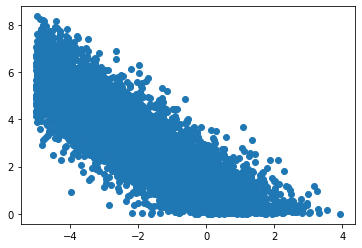

In [12]:
data = np.expand_dims(np.linspace(-2, 2, 100), 1)
data_pt = Tensor(data)
trunc_ols = LinearRegression().fit(x_trunc, y_trunc)

plt.scatter(x_trunc, y_trunc)
plt.plot(data, known_results(data_pt).detach().cpu(), color='green', label='known')
plt.plot(data, known_emp_results(data_pt).detach().cpu(), color='orange', label='known emp')
plt.plot(data, unknown_results(data_pt).detach().cpu(), color='yellow', label='unknown')
plt.plot(data , trunc_ols.predict(data), color='red', label='trunc ols')
plt.plot(data, ground_truth(data_pt), color='blue', label='gt std ols')
plt.legend()

# Results

100%|██████████| 2/2 [00:00<00:00,  5.09it/s]


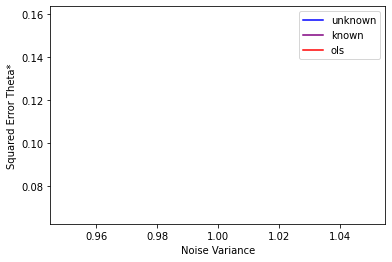

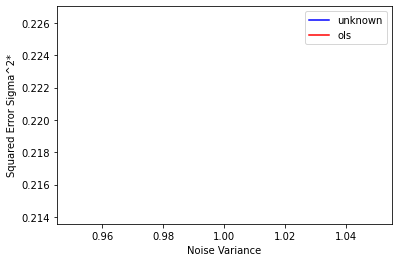

In [4]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
results.head()
reader.close() # close reader

# variance vs param mse
sns.lineplot(data=results, x='var', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=results, x='var', y='known_param_mse', label='known', color='purple')
ax = sns.lineplot(data=results, x='var', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error Theta*')
plt.show()

# var vs var mse
ax = sns.lineplot(data=results, x='var', y='unknown_var_mse', label='unknown', color='blue')
ax = sns.lineplot(data=results, x='var', y='ols_var_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error Sigma^2*')
plt.show()

In [5]:
results

,known_param_mse,unknown_param_mse,unknown_var_mse,ols_param_mse,ols_var_mse,alpha,var,exp_id
0,0.067113,0.087619,0.214188,0.158803,0.226417,0.6598,1.0,a6791cf1-57f0-4ddd-826c-1bb9a0015d4d


In [6]:
import matplotlib.pyplot as plt

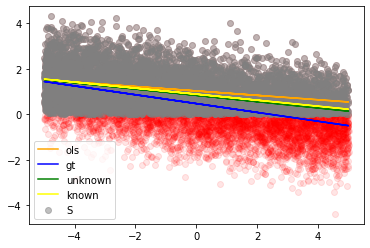

In [7]:
with ch.no_grad():
    plt.scatter(X, y, color='red', alpha=.1)
    plt.scatter(x_trunc, y_trunc, color='grey', label='S', alpha=.5)
    plt.plot(x_trunc, ols.predict(x_trunc), color="orange", label='ols')
    plt.plot(x_trunc, ground_truth(x_trunc), color='blue', label='gt')
    plt.plot(x_trunc, (x_trunc.mm(w_) + w0_), color='green', label='unknown')
    plt.plot(x_trunc, (x_trunc.mm(w) + w0), color='yellow', label='known')
    plt.legend()
    plt.show()

In [45]:
real_params

tensor([[-0.1939],
        [ 0.4694]], grad_fn=<CatBackward>)

In [25]:
from delphi import grad

trunc_mse = grad.TruncatedMSE.apply
trunc_unknown_mse = grad.TruncatedUnknownVarianceMSE.apply

In [34]:
pred = (x_trunc.mm(w_) + w0_)
pred.requires_grad = True
trunc_loss = trunc_mse(pred, y_trunc)

trunc_g, = ch.autograd.grad(trunc_loss, [pred])
trunc_g

tensor([[ 0.0002],
        [-0.0002],
        [ 0.0002],
        ...,
        [-0.0004],
        [-0.0004],
        [ 0.0002]])

In [35]:
alpha

tensor([0.2543])

In [30]:
import config

In [32]:
config.args.var = ols_var

In [38]:
ch.manual_seed(1)
# generate ground truth
ground_truth = ch.nn.Linear(in_features=args.in_features, out_features=1, bias=args.bias)
ground_truth.weight = ch.nn.Parameter(U.sample(ch.Size([1, args.in_features]))) 
ground_truth.bias = ch.nn.Parameter(U.sample(ch.Size([1, 1])))

# generate data
X = Uniform(-1, 1).sample(ch.Size([args.samples, args.in_features]))
y = ground_truth(X) + ch.sqrt(Tensor([var])) * ch.randn(y.size())
# truncate
indices = args.phi(y).nonzero(as_tuple=False).flatten()
y_trunc, x_trunc = y[indices].detach(), X[indices].detach()
alpha = Tensor([y_trunc.size(0)/args.samples])

In [39]:
alpha

tensor([0.6782])

In [1]:
import rpy2
print(rpy2.__version__)

ModuleNotFoundError: No module named 'rpy2'

In [ ]:
import subprocess 

command = 'Rscript'
path2scirpt = ''